In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from ape import accounts, chain, Contract, networks, project

In [3]:
# SEE: https://gist.github.com/banteg/dcf6082ff7fc6ad51ce220146f29d9ff
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [4]:
# USDC/WETH 5bps pool, 8h candles
FILEPATH = "data/price_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_12509859_17765859_2400.csv"

In [5]:
# TODO: pull from contract
X_DECIMALS = 6
Y_DECIMALS = 18

In [6]:
df = pd.read_csv(FILEPATH)
df

,block_number,sqrt_price_x96
0,12509859,1488666029357725662978369934166891
1,12512259,1498758880028447235204616864140268
2,12514659,1527428496431482073729729059235451
3,12517059,1480447266659661332123963148536664
4,12519459,1510557878125983516937970465170106
...,...,...
2185,17753859,1829209344494308734880463990390144
2186,17756259,1830429610097533257794674119254826
2187,17758659,1827296619717806012513766568630551
2188,17761059,1831453713649288095012480151677960


In [7]:
# calculate prices for both y/x and x/y in case of "weird" token0, token1 ordering
def price(sqrt_price_x96) -> int:
    return (int(sqrt_price_x96) >> 96) ** 2

In [8]:
df['y/x'] = df['sqrt_price_x96'].apply(price)

In [9]:
df['x/y'] = 10 ** Y_DECIMALS // df['y/x']

In [10]:
df

,block_number,sqrt_price_x96,y/x,x/y
0,12509859,1488666029357725662978369934166891,353026521,2832648372
1,12512259,1498758880028447235204616864140268,357815056,2794739861
2,12514659,1527428496431482073729729059235451,371641284,2690766723
3,12517059,1480447266659661332123963148536664,349129225,2864268953
4,12519459,1510557878125983516937970465170106,363474225,2751226720
...,...,...,...,...
2185,17753859,1829209344494308734880463990390144,533009569,1876138925
2186,17756259,1830429610097533257794674119254826,533748609,1873541182
2187,17758659,1827296619717806012513766568630551,531901969,1880045681
2188,17761059,1831453713649288095012480151677960,534349456,1871434486


<Axes: xlabel='block_number'>

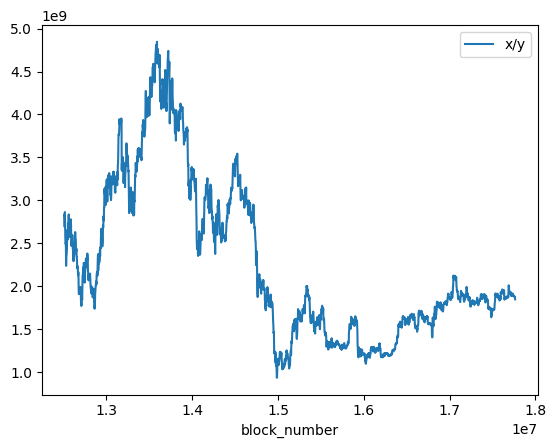

In [11]:
df.plot(x='block_number', y='x/y')

In [12]:
# calculate log differences for easier probability calcs. should have dlog(y/x) = -dlog(x/y)
df['dlog(y/x)'] = np.log(df['y/x']).diff()
df['dlog(x/y)'] = np.log(df['x/y']).diff()

In [13]:
df

,block_number,sqrt_price_x96,y/x,x/y,dlog(y/x),dlog(x/y)
0,12509859,1488666029357725662978369934166891,353026521,2832648372,NaN,NaN
1,12512259,1498758880028447235204616864140268,357815056,2794739861,0.013473,-0.013473
2,12514659,1527428496431482073729729059235451,371641284,2690766723,0.037913,-0.037913
3,12517059,1480447266659661332123963148536664,349129225,2864268953,-0.062487,0.062487
4,12519459,1510557878125983516937970465170106,363474225,2751226720,0.040266,-0.040266
...,...,...,...,...,...,...
2185,17753859,1829209344494308734880463990390144,533009569,1876138925,0.005986,-0.005986
2186,17756259,1830429610097533257794674119254826,533748609,1873541182,0.001386,-0.001386
2187,17758659,1827296619717806012513766568630551,531901969,1880045681,-0.003466,0.003466
2188,17761059,1831453713649288095012480151677960,534349456,1871434486,0.004591,-0.004591


<Axes: xlabel='block_number'>

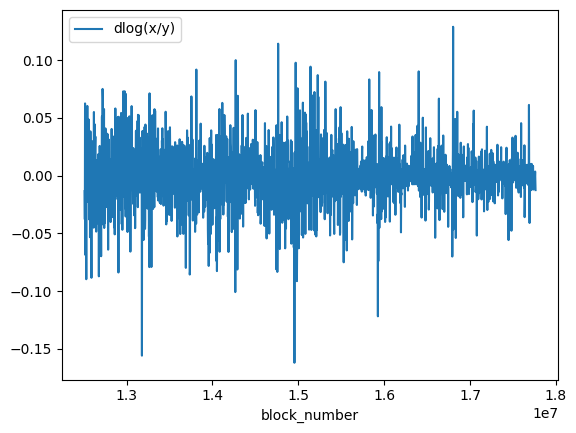

In [14]:
# plot log price diffs for x/y
df.plot(x='block_number', y='dlog(x/y)')

<Axes: ylabel='Frequency'>

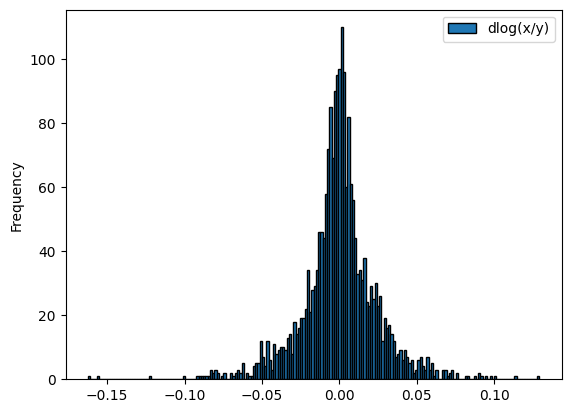

In [15]:
# histogram of log price diffs for x/y
df.plot(y='dlog(x/y)', kind='hist', bins=200, edgecolor='k')

In [16]:
# function to fit log price diffs to a few distributions
# SEE: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
def plot_fit_hist(df_data: pd.DataFrame, col: str, dists: list) -> dict:
    """
    Plots fits on top of histogram data. Returns fits for all dist names
    """
    params_data = {}

    df_data_col_notnull = df[df[col].notnull()][col]
    size = df_data_col_notnull.count()
    x = np.arange(-size // 2, size // 2 + 1, 1) / size
    x_lim_max = 1.1 * np.max([df_data_col_notnull.max(), np.abs(df_data_col_notnull.min())])
    
    ax = df_data.plot(y=col, kind='hist', bins=200, color='w', edgecolor='black', density=True, xlim=(-x_lim_max, x_lim_max))
    for dist in dists:
        params = getattr(stats, dist).fit(df_data_col_notnull)
        arg = params[:-2]
        pdf = getattr(stats, dist).pdf(x, *arg, loc=params[-2], scale=params[-1])
        df_pdf = pd.DataFrame(data={dist: pdf}, index=x)
        df_pdf.plot(ax=ax)
    
        # store param fits for later use in cell below
        params_data[dist] = [*params] + [None for _ in range(4 - len(params))]
    
    return params_data

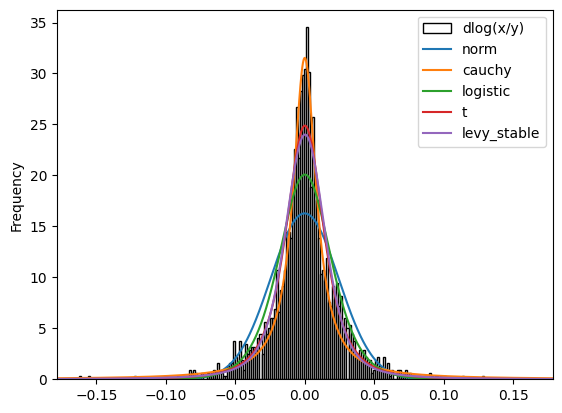

In [17]:
%%capture --no-display

params_data_8h = plot_fit_hist(df, 'dlog(x/y)', ['norm', 'cauchy', 'logistic', 't', 'levy_stable'])

In [18]:
# fit params to log price diffs on 8h candles
pd.DataFrame(data=params_data_8h).T

,0,1,2,3
norm,-0.000195,0.024510,NaN,NaN
cauchy,-0.000124,0.010094,NaN,NaN
logistic,-0.000002,0.012449,NaN,NaN
t,2.503086,0.000007,0.014541,NaN
levy_stable,1.461675,-0.006468,0.000008,0.012008


In [20]:
# TODO: combine candles to 24h, 3d, 7d to check time dependence approx scales as expected
df_24h = df.copy()
del df_24h['dlog(y/x)']
del df_24h['dlog(x/y)']

In [22]:
# optimal tick width calcs with period slider for various fits